In [6]:
import sys
import pickle
sys.path.append('..')    
sys.path.append('../letter_recognition')    
from letter_extraction import CompositeExtractor, ContoursExtractor, ThresholdDetector, EdgeDetector
from metrics import KeyboardLayout
from models import BaseDenseNet
from models import ConvDenseNet
from core import ImageGenerator
from utils.plot import *
from utils.model import *
from layout_estimation import LayoutUtils
from PIL import Image, ImageDraw

%matplotlib inline

In [2]:
def test_model(model, fragment_list):
    image_list = map(lambda x: x[1], fragment_list)
    image_data = np.array(image_list, dtype=np.float64).reshape(-1, 1, 32, 32)
    output_data = get_output_data(model, image_data)
    pred_list = map(lambda i: {
        'image': image_list[i], 
        'output': output_data[i], 
        'coord': fragment_list[i][0]
    }, range(len(fragment_list)))
    letter_preds_map = get_all_above_threshold(pred_list, 0.99)
    image_data = [pred['image'] for sublist in letter_preds_map.values() for pred in sublist]
    for image in image_data:
        plot_image(image)
    return letter_preds_map

model = load_base_dense_net('../letter_recognition/state_dicts/eval/in_place_m20_base_dense.pt', 20)
model.eval()

BaseDenseNet(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (dense1): Sequential(
    (0): Bottleneck(
      (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): Bottleneck(
      (bn1): BatchNorm2d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn2): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (trans1): Transition(
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_s

Fragments count: 1424


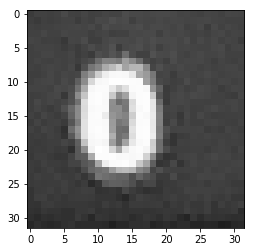

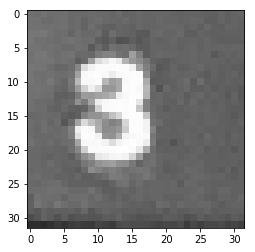

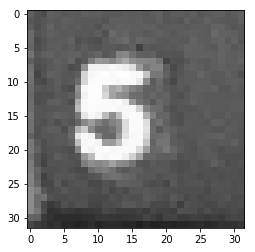

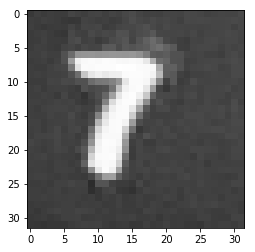

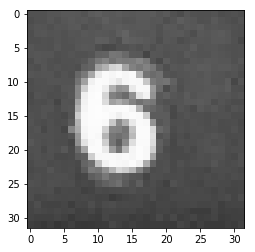

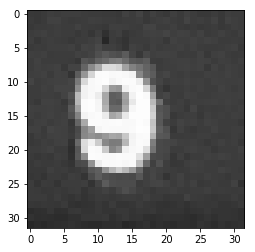

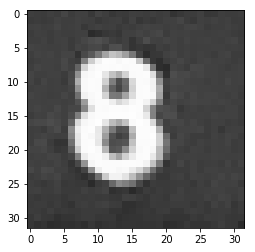

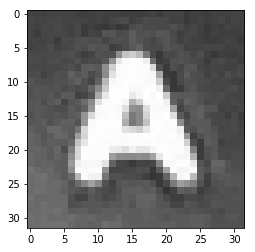

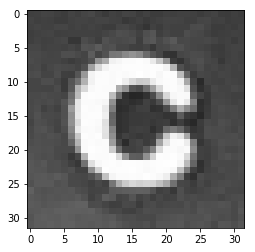

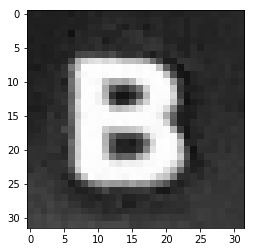

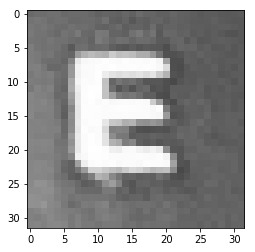

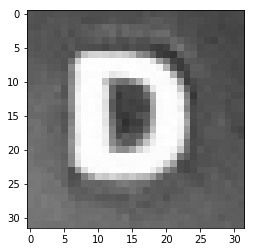

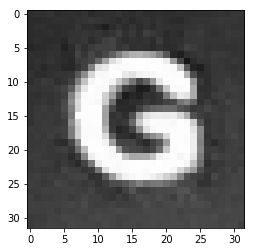

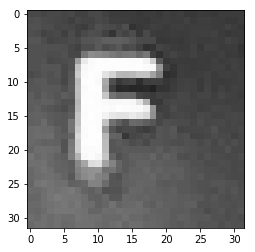

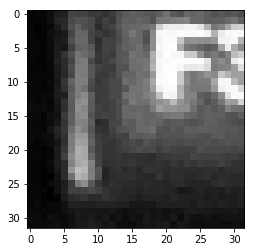

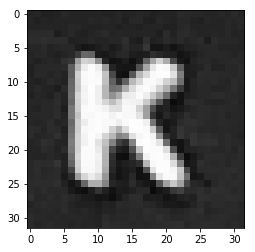

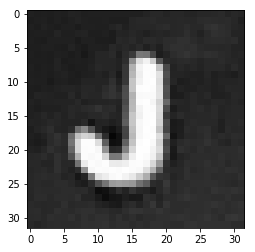

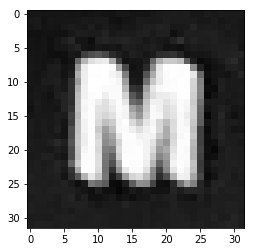

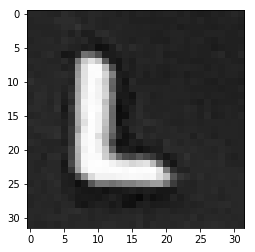

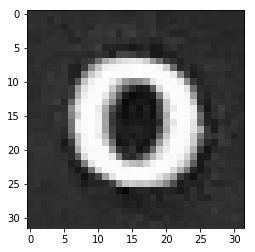

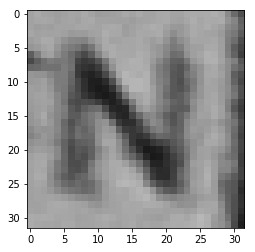

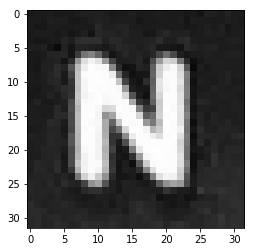

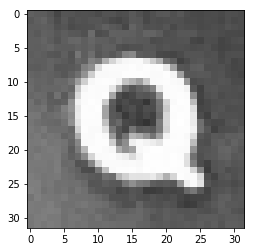

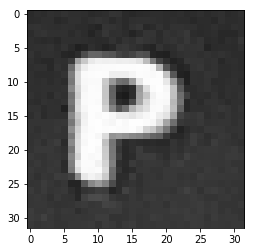

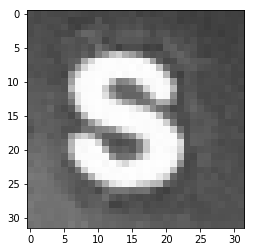

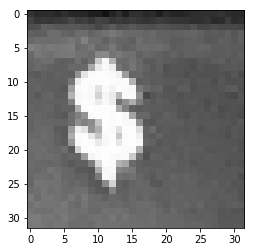

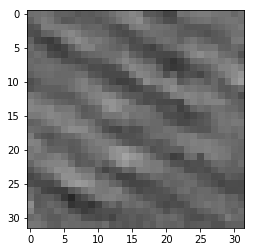

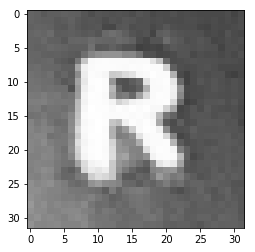

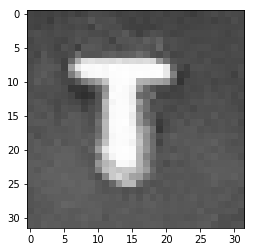

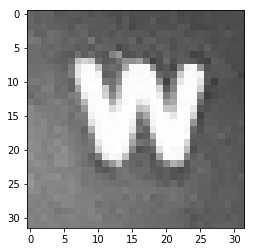

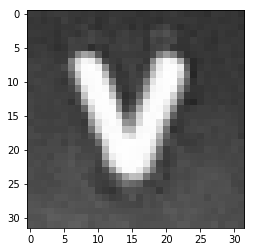

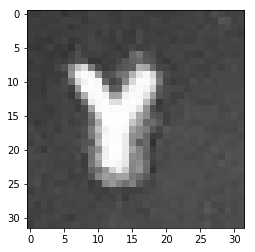

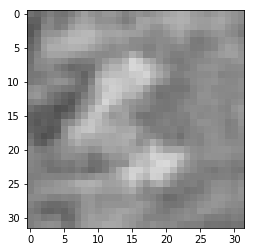

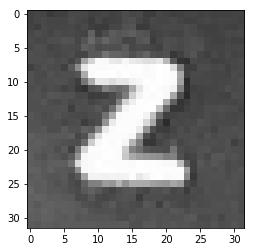

In [4]:
thres_detector = ContoursExtractor(ThresholdDetector())
edge_detector = ContoursExtractor(EdgeDetector())
contours_extractor = CompositeExtractor([thres_detector, edge_detector])
keyboard_layout = KeyboardLayout("../keyboards/layouts/keyboard1.layout", '../')
fragment_list = thres_detector.get_fragment_list(keyboard_layout.get_image())
print("Fragments count: {}".format(len(fragment_list)))
letter_preds_map = test_model(model, fragment_list[:1000])

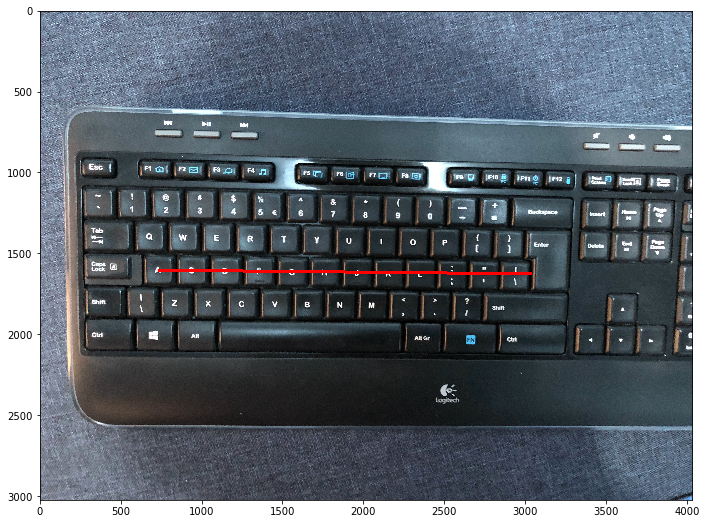

In [5]:
def get_middle_point(coord):
    ps, pe = coord['start_pos'], coord['end_pos']
    return ((ps[0] + pe[0]) / 2, (ps[1] + pe[1]) / 2)

def test_pair(elem1, elem2):
    middle1 = get_middle_point(elem1['coord'])
    middle2 = get_middle_point(elem2['coord'])
    middle2 = (middle2[0] + (middle2[0] - middle1[0]) * 10, middle2[1] + (middle2[1] - middle1[1]) * 10)
    image_draw = ImageDraw.Draw(pil_image)
    image_draw.line(middle1 + middle2, fill=255, width=20)
    del image_draw
    plt.figure(figsize=(14, 9))        
    plt.imshow(pil_image)
    plt.show()       

pil_image = Image.fromarray(keyboard_layout.get_image())        
test_pair(letter_preds_map['A'][0], letter_preds_map['S'][0])    

In [9]:
def get_possible_triples():
    all_letters = string.ascii_uppercase + string.digits
    letter_row_list = map(lambda x: (x, LayoutUtils.get_letter_row_index(x)), all_letters)
    row_letters_map = 
    
get_possible_triples()